<a href="https://colab.research.google.com/github/Farhadsed75/New-Fine-tuning/blob/main/Fine_tuning_RAG_modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install evaluate
!pip install llama-index
!pip install llama-index-embeddings-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import evaluate    # which is from huggingface
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch
from transformers import DataCollatorWithPadding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings, SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor

In [ ]:
# load dataset
import pandas as pd
from datasets import Dataset, DatasetDict

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
val_df = pd.read_csv("/content/val.csv")

# Assuming Real.pdf is in /content
!mkdir -p /content/wildfire_pdfs
!mkdir -p /content/tsunami_pdfs

!mv /content/1_After_Action_Report.pdf /content/wildfire_pdfs/

!mv /content/1_report.pdf /content/tsunami_pdfs/
!mv /content/2_comprehensive_report.pdf /content/tsunami_pdfs/

mv: cannot stat '/content/1_After_Action_Report.pdf': No such file or directory
mv: cannot stat '/content/1_report.pdf': No such file or directory
mv: cannot stat '/content/2_comprehensive_report.pdf': No such file or directory


In [ ]:
### Define Settings ###

# import any embedding model on HF hub (https://huggingface.co/spaces/mteb/leaderboard)

Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5") # but the embedding model for llama is open ai

# Settings.embed_model = HuggingFaceEmbedding(model_name="thenlper/gte-large") # alternative model

Settings.llm = None
Settings.chunk_size = 256      # number of characters in each chunk
Settings.chunk_overlap = 25    # overlapping between two consecutive chunks to avoid chopping the key concept of each chunk

### Function to Build Context ###
def build_combined_context(folder_path):
    documents = SimpleDirectoryReader(folder_path).load_data()  # so it will read all of the three articles in pdf formats then chunk them all
    index = VectorStoreIndex.from_documents(documents)          # store remaining chunks into a vector data store, store docs into vector DB
    retriever = VectorIndexRetriever(index=index, similarity_top_k=3)
    query_engine = RetrieverQueryEngine(
        retriever=retriever,
        node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.5)],
    )                                                           # it takes in the user query and spits out the relevant content
    # Generic query to get general relevant info
    response = query_engine.query("What factors influenced people's decisions to evacuate by foot, evacuate by vehicle, or stay at home during natural disasters?")  # it will generate the response including top 3 most relevant chunks
    combined_context = "\n".join([node.text for node in response.source_nodes[:3]])        # Combine the top 3 source nodes into one string
    return combined_context

# Build separate contexts
wildfire_context = build_combined_context("/content/wildfire_pdfs")
tsunami_context = build_combined_context("/content/tsunami_pdfs")


LLM is explicitly disabled. Using MockLLM.


In [ ]:
wildfire_context

"Without \nclear shift changes, individuals were often left serving in multiple roles for extended periods, leading \nto fatigue, role ambiguity, and diminished accountability. This situation created uncertainty about role \nresponsibilities, impacted information flow, and complicated the transition between operational \nperiods.\nExternal factors, like power outages and loss of cellular service, worsened communication challenges, \nbut internal issues also compounded these difficulties. This gap in information flow led to delays in \nalerting the public and mobilizing resources. \nDue to inadequate situational awareness, the EOC experienced delays in issuing alerts, organizing \nshelter resources, and deploying personnel. Incident commanders, overwhelmed by tactical \nresponses, could not  provide timely updates to the EOC. The lack of real -time updates led to\nIt became clear early in the response that a \nlarge number of people would need  shelter, which further challenged operatio

In [ ]:
# load dataset
import pandas as pd
from datasets import Dataset, DatasetDict

### Append Context Based on Type ###
def append_context(row):
    if row['type'].lower() == 'wildfire':
        return str(row['text']) + "\n" + wildfire_context
    elif row['type'].lower() == 'tsunami':
        return str(row['text']) + "\n" + tsunami_context

# Apply to all datasets
train_df['text'] = train_df.apply(append_context, axis=1)
test_df['text'] = test_df.apply(append_context, axis=1)
val_df['text'] = val_df.apply(append_context, axis=1)

train_df = train_df.drop('type',axis=1)
test_df = test_df.drop('type',axis=1)
val_df = val_df.drop('type',axis=1)

# Convert Pandas DataFrames to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

# Create a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "val": val_dataset
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1140
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 244
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 245
    })
})

In [ ]:
# Load pretrained model directly
model_path = "google/bigbird-roberta-base" # pretrained model path consisting 110 million parameters

# load model tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# load model with classification head
id2label = {0: "evacuated by foot", 1: "evacuated by vehicle", 2:"stayed at home"}
label2id = {"evacuated by foot":0, "evacuated by vehicle":1, "stayed at home":2}
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=3,
                                                           id2label=id2label,
                                                           label2id=label2id,)
# after this, all 110 parameters are ready to be trained however we dont want to train all of them,
# instead we wanna freeze most of them (Doing transfer learning).

# freeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

# after this, all the base model parameters are frozen and
# only the parameters in that classification head that we slapped on top of the model are trainable
# In other words, we freeze all of the layers except for four last layers (pooler layers)

# Data Preprocessing

# define text preprocessing
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=4096)

# tokenize all dataset
tokenized_data = dataset.map(preprocess_function, batched=True)

# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # To ensure that every batch has the same length

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1140 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

In [ ]:
# Define evaluation metrics

# load metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    # get predictions
    predictions, label = eval_pred  # predictions will be logit, a number between -1 and 1

    # apply softmax to get probabilities
    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)*100
    probabilities = pd.DataFrame(probabilities, columns=["Prob_foot", "Prob_vehicle", "Prob_stay"]).round(1)
    probabilities.to_csv("probabilities.csv", index=True)

    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)

    # compute metrics
    acc = np.round(accuracy.compute(predictions=predicted_classes, references=label)['accuracy'],3) # round to three decimal places
    f1_score = np.round(f1.compute(predictions=predicted_classes, references=label, average="macro")["f1"], 3)
    precision_score = np.round(precision.compute(predictions=predicted_classes, references=label, average="macro")["precision"], 3)
    recall_score = np.round(recall.compute(predictions=predicted_classes, references=label, average="macro")["recall"], 3)
    cm = confusion_matrix(label, predicted_classes)
    report = classification_report(label, predicted_classes, target_names=["foot", "vehicle", "stay"], output_dict=True)

    # store metrics
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv("classification_report.csv", index=True)

    cm_df = pd.DataFrame(cm, index=["Actual_foot", "Actual_vehicle", "Actual_stay"],
                             columns=["Pred_foot", "Pred_vehicle", "Pred_stay"])
    cm_df.to_csv("confusion_matrix.csv", index=True)

    summary_df = pd.DataFrame({
        "Metric": ["Accuracy", "F1", "Precision", "Recall"],
        "Value": [acc, f1_score, precision_score, recall_score]
    })
    summary_df.to_csv("summary_metrics.csv", index=False)

    return {"Accuracy": acc,
            "F1": f1_score,
            "Precision": precision_score,
            "Recall": recall_score}

In [ ]:
# Training parameters

# hyperparameters
lr = 2e-4
batch_size = 8
num_epochs = 25

training_args = TrainingArguments(
    output_dir="bert-phishing-classifier_teacher",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_strategy="epoch",     # this says how often the trainer will print the training loss
    eval_strategy="epoch",        # this says how often the trainer will print the evaluation metrics
    save_strategy="epoch",        # model get saved at each epochs
    load_best_model_at_end=True,  # if the 8th epoch is the best epoch, it will print by 8th epoch, instead of printing by 10th epoch
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

# Generate prediction using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-20-d82fbb7bdec6>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Input ids are automatically padded from 3171 to 3200 to be a multiple of `config.block_size`: 64


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
a = []
for i in range(len(dataset['train']['text'])):
  tokens1 = tokenizer.tokenize(dataset['train']['text'][i])
  a.append(len(tokens1))
max(a)

Token indices sequence length is longer than the specified maximum sequence length for this model (1724 > 512). Running this sequence through the model will result in indexing errors


1936

In [ ]:
# === Evaluate on Validation Set (val) ===

# apply model to independent validation dataset
# This validation data was not used for training the model parameters or tuning the hyperparameters
# so it gives us the fair evaluation of the model

# Get logits and label from validation set
val_predictions = trainer.predict(tokenized_data["val"])

# Extract raw logits and true label
logits = val_predictions.predictions
label = val_predictions.label_ids

# Compute predicted class label
predicted_classes = np.argmax(logits, axis=1)

# === Compute & Save Evaluation Metrics ===
val_acc = np.round(accuracy.compute(predictions=predicted_classes, references=label)['accuracy'], 3)
val_f1 = np.round(f1.compute(predictions=predicted_classes, references=label, average="macro")["f1"], 3)
val_precision = np.round(precision.compute(predictions=predicted_classes, references=label, average="macro")["precision"], 3)
val_recall = np.round(recall.compute(predictions=predicted_classes, references=label, average="macro")["recall"], 3)
val_cm = confusion_matrix(label, predicted_classes)
val_report = classification_report(label, predicted_classes, target_names=["foot", "vehicle", "stay"], output_dict=True)

# === Save Metrics to CSV Files ===
val_report_df = pd.DataFrame(val_report).transpose()
val_report_df.to_csv("val_classification_report.csv", index=True)

val_cm_df = pd.DataFrame(val_cm, index=["Actual_foot", "Actual_vehicle", "Actual_stay"],
                         columns=["Pred_foot", "Pred_vehicle", "Pred_stay"])
val_cm_df.to_csv("val_confusion_matrix.csv", index=True)

val_summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1", "Precision", "Recall"],
    "Value": [val_acc, val_f1, val_precision, val_recall]
})
val_summary_df.to_csv("val_summary_metrics.csv", index=False)

val_probabilities = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)*100
val_probabilities = pd.DataFrame(val_probabilities, columns=["Prob_foot", "Prob_vehicle", "Prob_stay"]).round(1)
val_probabilities.to_csv("val_probabilities.csv", index=True)

# Our accuracy will be good indicating. So this is a good sign that our model is not overfitted :)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
val_summary_df

,Metric,Value
0,Accuracy,0.683
1,F1,0.502
2,Precision,0.460
3,Recall,0.553


In [ ]:
val_report

{'foot': {'precision': 0.711864406779661,
  'recall': 0.84,
  'f1-score': 0.7706422018348624,
  'support': 50.0},
 'vehicle': {'precision': 0.6666666666666666,
  'recall': 0.8192771084337349,
  'f1-score': 0.7351351351351352,
  'support': 83.0},
 'stay': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 28.0},
 'accuracy': 0.6832298136645962,
 'macro avg': {'precision': 0.4595103578154425,
  'recall': 0.5530923694779116,
  'f1-score': 0.5019257789899992,
  'support': 161.0},
 'weighted avg': {'precision': 0.5647612029336421,
  'recall': 0.6832298136645962,
  'f1-score': 0.6183125857637226,
  'support': 161.0}}

In [ ]:
import pandas as pd

# Extract training logs
training_logs = trainer.state.log_history

# Convert to DataFrame
df_logs = pd.DataFrame(training_logs)
df_logs1 = df_logs[['epoch', 'loss', 'eval_loss', 'eval_Accuracy']]

# Fill NaN values in the 'loss' column with the previous value
df_logs1['loss'].fillna(method='ffill', inplace=True)

# Remove rows where 'eval_loss' is NaN
df_logs1.dropna(subset=['eval_loss'], inplace=True)

df_logs1

<ipython-input-22-e48d10dd1ad9>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_logs1['loss'].fillna(method='ffill', inplace=True)
<ipython-input-22-e48d10dd1ad9>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_logs1['loss'].fillna(method='ffill', inplace=True)
<ipython-input-22-e48d10dd1ad9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

,epoch,loss,eval_loss,eval_Accuracy
1,1.0,1.0159,0.938007,0.506
3,2.0,0.9720,0.881539,0.556
5,3.0,0.9512,0.832028,0.594
7,4.0,0.8978,0.836990,0.569
9,5.0,0.8712,0.771217,0.706
11,6.0,0.8781,0.762121,0.662
13,7.0,0.8676,0.727501,0.725
15,8.0,0.8564,0.723079,0.725
17,9.0,0.8528,0.713930,0.725
19,10.0,0.8554,0.728299,0.700


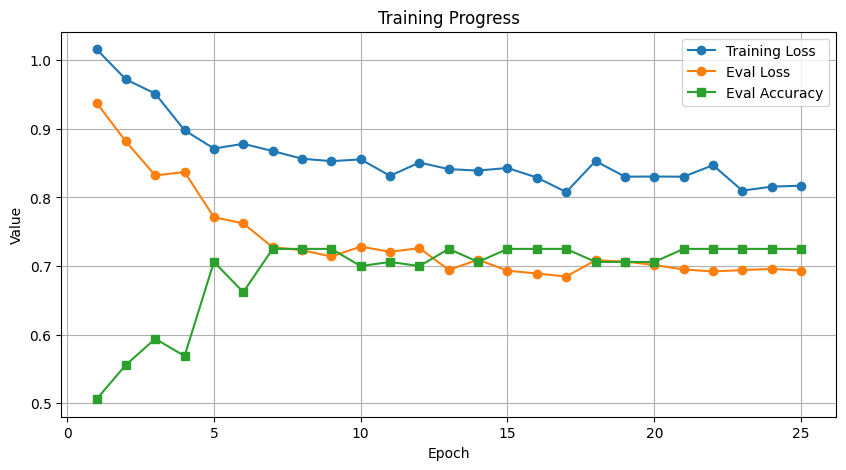

In [ ]:
import matplotlib.pyplot as plt

# Plot the training logs
plt.figure(figsize=(10, 5))

# Plot evaluation loss
plt.plot(df_logs1['epoch'], df_logs1['loss'], label='Training Loss', marker='o', linestyle='-')

# Plot evaluation loss
plt.plot(df_logs1['epoch'], df_logs1['eval_loss'], label='Eval Loss', marker='o', linestyle='-')

# Plot evaluation accuracy
plt.plot(df_logs1['epoch'], df_logs1['eval_Accuracy'], label='Eval Accuracy', marker='s', linestyle='-')

# Label and title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

# Show the plot
# plt.savefig("training_progress.jpg", dpi = 1000 , bbox_inches = 'tight')
plt.show()